<h1 style="font-size:30px;">Neural Network Optimizers</h1>

Thus far in the course, we have used various optimizers to train models and reviewed the theory for four different types (SGD, SGD + Momentum, RMSProp, and Adam). `torch.optim` is a PyTorch module with various optimization algorithms. It would help if you visited the documentation pages <a href="https://pytorch.org/docs/stable/optim.html" target=_blank>here</a> to learn more about the parameters available for each.

In this notebook, we will compare four different optimizers using the LeNet5 model and the Fashion MNIST dataset. We will train the model four different times using different optimizers. In each case, we will use the same learning rate for each optimizer and plot the **training** loss as shown below to get a better feel for the convergence properties of each optimizer.

<img src='https://opencv.org/wp-content/uploads/2023/05/c3_w4_optimizers_cover.png' align='center' width='900'>

In [ ]:
import os
import gc
import random
import warnings
from dataclasses import dataclass
from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)

%matplotlib inline
warnings.filterwarnings(action='ignore', category=UserWarning)

In [ ]:
def system_config(SEED_VALUE=42, package_list=None):
    """
    Configures the system environment for PyTorch-based operations.

    Args:
        SEED_VALUE (int): Seed value for random number generation. Default is 42.
        package_list (str): String containing a list of additional packages to install
        for Google Colab or Kaggle. Default is None.

    Returns:
        tuple: A tuple containing the device name as a string and a boolean indicating GPU availability.
    """

    random.seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    torch.manual_seed(SEED_VALUE)

    def is_running_in_colab():
        return 'COLAB_GPU' in os.environ

    def is_running_in_kaggle():
        return 'KAGGLE_KERNEL_RUN_TYPE' in os.environ

    #--------------------------------
    # Check for the availability GPUs.
    #--------------------------------
    if torch.cuda.is_available():
        print('Using CUDA GPU')

        # This section for installing packages required by Colab.
        if is_running_in_colab() or is_running_in_kaggle():
            print('Installing required packages...')
            !pip install {package_list}

        # Set the device to the first CUDA device.
        DEVICE = torch.device('cuda')
        print("Device: ", DEVICE)
        GPU_AVAILABLE = True

        torch.cuda.manual_seed(SEED_VALUE)
        torch.cuda.manual_seed_all(SEED_VALUE)

        # Performance and deterministic behavior.
        torch.backends.cudnn.enabled = True       # Provides highly optimized primitives for DL operations.
        torch.backends.cudnn.deterministic = True # Insures deterministic even when above cudnn is enabled.
        torch.backends.cudnn.benchmark = False    # Setting to True can cause non-deterministic behavior.

    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        print('Using Apple Silicon GPU')

        # Set the device to the Apple Silicon GPU Metal Performance Shader (MPS).
        DEVICE = torch.device("mps")
        print("Device: ", DEVICE)
        # Environment variable that allows PyTorch to fall back to CPU execution
        # when encountering operations that are not currently supported by MPS.
        os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
        GPU_AVAILABLE = True

        torch.mps.manual_seed(SEED_VALUE)
        torch.use_deterministic_algorithms(True)

    else:
        print('Using CPU')
        DEVICE = torch.device('cpu')
        print("Device: ", DEVICE)
        GPU_AVAILABLE = False

        if is_running_in_colab() or is_running_in_kaggle():
            print('Installing required packages...')
            !pip install -q {package_list}
            print('Note: Change runtime type to GPU for better performance.')

        torch.use_deterministic_algorithms(True)

    return str(DEVICE), GPU_AVAILABLE

In [ ]:
# Additional packages required for Google Colab or Kaggle.
package_list = "torchmetrics livelossplot torchinfo tqdm"

DEVICE, GPU_AVAILABLE = system_config(package_list=package_list)

In [ ]:
from tqdm import tqdm
from torchinfo import summary
from torchmetrics import MeanMetric
from torchmetrics.classification import MulticlassAccuracy

We are defining two small helper function for reproducibility and to get the acceleration hardware available.

## 1 Training and Dataset Configurations

In [ ]:
@dataclass(frozen=True)
class DatasetConfig:
    HEIGHT:      int = 32
    WIDTH:       int = 32
    CHANNELS:    int = 1
    NUM_CLASSES: int = 10
    MEAN:      tuple = (0.2860,)
    STD:       tuple = (0.3530,)
    DATA_ROOT:   str = "data"


@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:      int = 128
    NUM_EPOCHS:      int = 11
    LEARNING_RATE: float = 0.001
    NUM_WORKERS:     int = 0

## 2 Fashion MNIST Dataset


The Fashion MNIST dataset is very similar to MNIST handwritten digits dataset, consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

<img src='https://opencv.org/wp-content/uploads/2023/05/c3-w4-fashion-MNIST.png' width=700 align='center'><br/>

### 2.1 Create DataLoaders

In [ ]:
def get_data(resize_to=(32, 32), batch_size=32, pin_memory=False, data_root="data", num_workers=0):

    # We will only apply pre-processing transformations to the train and valid dataset.
    preprocessing_transforms = transforms.Compose(
        [
            # Resize image.
            transforms.Resize(resize_to),

            # Re-scale image tensor values between 0-1. image_tensor /= 255
            transforms.ToTensor(),

            # Normalize image by Subtracting mean (0.2860) and divide by variance (0.3530) of the training dataset.
            transforms.Normalize(DatasetConfig.MEAN, DatasetConfig.STD),
        ]
    )

    # Initialize train dataloader
    train_loader = DataLoader(
        datasets.FashionMNIST(root=data_root, train=True, download=True, transform=preprocessing_transforms),
        batch_size=batch_size,
        pin_memory=pin_memory,
        shuffle=True,
        num_workers=num_workers,
    )

    # Initialize valid dataloader
    valid_loader = DataLoader(
        datasets.FashionMNIST(root=data_root, train=False, download=True, transform=preprocessing_transforms),
        batch_size=batch_size,
        pin_memory=pin_memory,
        shuffle=False,
        num_workers=num_workers,
    )
    return train_loader, valid_loader

### 2.2 Data Visualization

In [ ]:
# This function is used for reversing the Normalization step performed during image preprocessing.
# Note the mean and std values must match the ones used.

def denormalize(tensors, *, mean, std):
    """Denormalizes image tensors using mean and std provided
    and clip values between 0 and 1"""

    for c in range(DatasetConfig.CHANNELS):
        tensors[:, c, :, :].mul_(std[c]).add_(mean[c])

    return torch.clamp(tensors, min=0.0, max=1.0)

In [ ]:
def visualize_samples(loader):

    plt.figure(figsize=(18, 8))

    for X, y in loader:

        images = denormalize(X, mean=DatasetConfig.MEAN, std=DatasetConfig.STD).squeeze().numpy()
        target = y.numpy()


        for i in range(8):
            plt.subplot(2, 4, i + 1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(images[i], cmap='gray')
            plt.xlabel(target[i], fontsize=20)

        plt.suptitle('Dataset Samples', fontsize=18)
        plt.subplots_adjust(wspace=0.2, hspace=0.2)
        plt.show()
        plt.close()

        break

    return

100%|█████████████████████████████████████████| 26421880/26421880 [00:12<00:00, 2079053.68it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|████████████████████████████████████████████████| 29515/29515 [00:00<00:00, 185635.70it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|███████████████████████████████████████████| 4422102/4422102 [00:03<00:00, 1271552.39it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|████████████████████████████████████████████████| 5148/5148 [00:00<00:00, 10589640.51it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



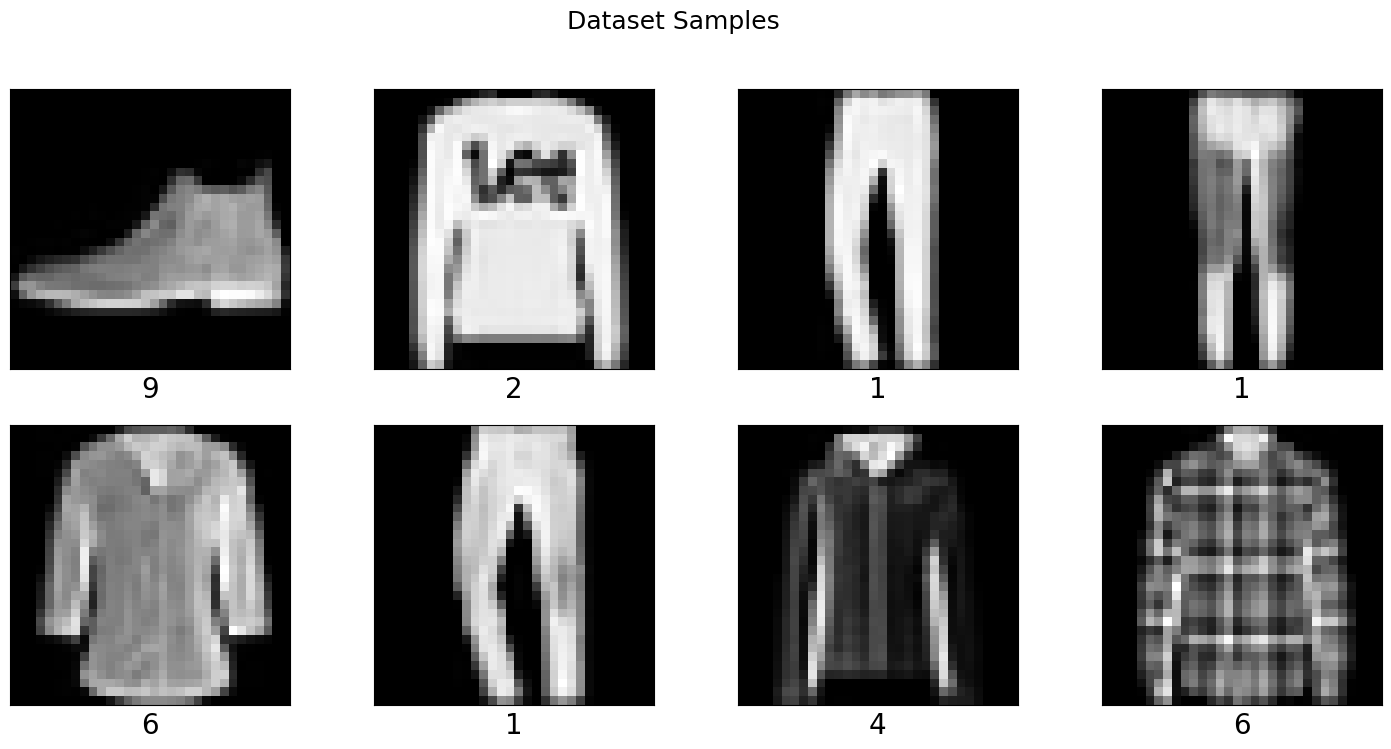

In [ ]:
train_loader, valid_loader = get_data(
    resize_to=(DatasetConfig.HEIGHT, DatasetConfig.WIDTH),
    batch_size=TrainingConfig.BATCH_SIZE,
    data_root=DatasetConfig.DATA_ROOT,
)

visualize_samples(valid_loader)

## 3 LeNet5 Model

In [ ]:
class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        # convolution layers
        self._body = nn.Sequential(
            nn.Conv2d(in_channels=DatasetConfig.CHANNELS, out_channels=6, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )

        # Fully connected layers
        self._head = nn.Sequential(
            # flatten the output of conv layers
            nn.Flatten(),

            nn.Linear(in_features=16 * 5 * 5, out_features=120),
            nn.ReLU(inplace=True),

            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(inplace=True),

            nn.Linear(in_features=84, out_features=num_classes)
        )

    def forward(self, x):
        # apply feature extractor
        x = self._body(x)

        # apply classification head
        x = self._head(x)
        return x

### 3.1 Print Model Summary

In [ ]:
lenet_model = LeNet5(num_classes=DatasetConfig.NUM_CLASSES)

summary(lenet_model, input_size=(1, DatasetConfig.CHANNELS, DatasetConfig.HEIGHT, DatasetConfig.WIDTH))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet5                                   [1, 10]                   --
├─Sequential: 1-1                        [1, 16, 5, 5]             --
│    └─Conv2d: 2-1                       [1, 6, 28, 28]            156
│    └─ReLU: 2-2                         [1, 6, 28, 28]            --
│    └─MaxPool2d: 2-3                    [1, 6, 14, 14]            --
│    └─Conv2d: 2-4                       [1, 16, 10, 10]           2,416
│    └─ReLU: 2-5                         [1, 16, 10, 10]           --
│    └─MaxPool2d: 2-6                    [1, 16, 5, 5]             --
├─Sequential: 1-2                        [1, 10]                   --
│    └─Flatten: 2-7                      [1, 400]                  --
│    └─Linear: 2-8                       [1, 120]                  48,120
│    └─ReLU: 2-9                         [1, 120]                  --
│    └─Linear: 2-10                      [1, 84]                   10,164
│  

## 4 Training and Validation Helper functions

Next we are defining the `train_one_epoch` and `validate` function. The function definitions are basically the same as in the previous notebooks.

1. `train_one_epoch(...)` - This function is used to perform 1 epoch of training where parameters of the model are updated.
2. `validate(...)` - This function is used to evaluate how good the model performs on unseen images.

Both the `train_one_epoch(...)` and `validate(...)` functions utilize the `tqdm` package to display a progress bar during training and evaluation stages, which visually represents the progress of the training and evaluation loops. The bar displays the running loss and accuracy of the model.

In [ ]:
def train_one_epoch(
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader,
    device: torch.device,
    num_classes: int,
    epoch_idx: int,
    total_epochs: int,
):
    # Set model to training mode.
    model.train()

    # Torchmetrics classes used to record and calulate loss and accuracy
    loss_record = MeanMetric()
    acc_record  = MulticlassAccuracy(num_classes=num_classes, average="micro")

    loader_len = len(train_loader)

    with tqdm(total=loader_len, ncols=122, ascii=True) as tq:
        tq.set_description(f"Train :: Epoch: {epoch_idx}/{total_epochs}")

        for data, target in train_loader:
            tq.update(1)

            # Send data and target to GPU device if available.
            data   = data.to(device)
            target = target.to(device)

            # Reset parameters gradient to zero.
            optimizer.zero_grad()

            # Perform forward pass through the model.
            logits = model(data)

            # Calculate Cross-entropy loss.
            loss = F.cross_entropy(logits, target)

            # Find gradients w.r.t training parameters.
            loss.backward()

            # Update parameters using gradients.
            optimizer.step()

            # Record loss.
            loss_record.update(loss.detach().cpu(), weight=data.shape[0])

            # Get the index of node with max score.
            pred = torch.argmax(logits, dim=1)

            # Calculate and record accuracy.
            acc_record.update(pred.cpu(), target.cpu())

            # Update progress bar description with running mean and accuracy values.
            tq.set_postfix_str(s=f"Loss: {loss_record.compute():.4f}, Acc: {acc_record.compute():.4f}")

    # Get final loss and accuracy.
    # The values are the same as the one displayed for the final iteration.
    epoch_loss = loss_record.compute()
    epoch_acc  = acc_record.compute()

    return epoch_loss.item(), epoch_acc.item()

In [ ]:
def validate(
    model: nn.Module,
    valid_loader: torch.utils.data.DataLoader,
    device: torch.device,
    num_classes: int,
    epoch_idx: int,
    total_epochs: int
):

    # Set model in evaluation mode.
    model.eval()

    loss_record = MeanMetric()
    acc_record = MulticlassAccuracy(num_classes=num_classes, average="micro")

    loader_len = len(valid_loader)

    with tqdm(total=loader_len, ncols=122, ascii=True) as tq:
        tq.set_description(f"Valid :: Epoch: {epoch_idx}/{total_epochs}")

        for data, target in valid_loader:
            tq.update(1)

            # Send data and target to GPU device if available.
            data     = data.to(device)
            target = target.to(device)

            with torch.no_grad():
                # Perform forward pass through the model.
                logits = model(data)

            # Calculate Cross-entropy loss.
            loss = F.cross_entropy(logits, target)

            # Record loss.
            loss_record.update(loss.cpu(), weight=data.shape[0])

            # Get the index of node with max score.
            pred = torch.argmax(logits, dim=1)

            # Calculate and record accuracy
            acc_record.update(pred.cpu(), target.cpu())

        valid_epoch_loss = loss_record.compute()
        valid_epoch_acc  = acc_record.compute()

        # Update progress bar description to display epoch log.
        tq.set_postfix_str(s=f"Loss: {valid_epoch_loss:.4f}, Acc: {valid_epoch_acc:.4f}")

    return valid_epoch_loss.item(), valid_epoch_acc.item()

## 5 Main function for Training

Some of important actions and repetitive actions that will be performed inside the `main(...)` function are as follows:

1. Load the data using dataloaders.
2. Set up variables to track loss and accuracy during training.
3. For each epoch, call train function and validate function

In [ ]:
def main(model, optimizer, device, pin_memory=False):

    # Intialize train and valid dataloaders.
    train_loader, valid_loader = get_data(
        resize_to   = (DatasetConfig.HEIGHT, DatasetConfig.WIDTH),
        batch_size  = TrainingConfig.BATCH_SIZE,
        pin_memory  = pin_memory,
        data_root   = DatasetConfig.DATA_ROOT,
        num_workers = TrainingConfig.NUM_WORKERS
    )

    # Accumulate train and valid per epoch metric.
    epoch_train_acc = []
    epoch_valid_acc = []
    epoch_train_loss = []
    epoch_valid_loss = []

    total_epochs = TrainingConfig.NUM_EPOCHS

    # # # Compile Model.
    # # Uncomment this line if you are using PyTorch 2.0.
    # # Sometimes compilation can also lead to error, do a test run with few epochs
    # # to ensure the code runs without any error. If it doesn't turn off compilation.
    # model = torch.compile(model)

    for epoch in range(total_epochs):
        # Clear display.
        clear_output()

        # Train for one epoch.
        train_loss, train_acc = train_one_epoch(model, optimizer, train_loader, device, DatasetConfig.NUM_CLASSES, epoch+1, total_epochs)

        # Perform validation run.
        valid_loss, valid_acc = validate(model, valid_loader, device, DatasetConfig.NUM_CLASSES, epoch+1, total_epochs)

        # Collect epoch loss and accuracy
        epoch_train_loss.append(train_loss)
        epoch_valid_loss.append(valid_loss)

        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)

    del model
    del optimizer
    del train_loader
    del valid_loader
    gc.collect()
    torch.cuda.empty_cache()

    return epoch_train_acc, epoch_train_loss, epoch_valid_acc, epoch_valid_loss

## 6 Training using SGD (Gradient Descent)

**Gradient descent update rule:**

$$
\normalsize{W_t = W_{t-1} -\alpha g_{t-1}}
$$

where,

$$
W = \begin{bmatrix}
           w_{1} \\
           w_{2} \\
           \vdots \\
           w_{n}
         \end{bmatrix}
$$

and,


$$
g = \begin{bmatrix}
           \frac{\partial L}{\partial w_1} \\
           \frac{\partial L}{\partial w_2}  \\
           \vdots \\
           \frac{\partial L}{\partial w_n}
         \end{bmatrix}
$$


---

**For stochastic gradient descent update, we are using the `torch.optim.SGD` class available in PyTorch with the following arguments:**


```python
torch.optim.SGD(params,
                lr=<required parameter>,
                momentum=0,
                dampening=0,
                weight_decay=0,
                nesterov=False
               )
```

---

***Parameters:***

- **`params`** (iterable) – Iterable of parameters to optimize or dicts defining parameter groups. `model.parameters()` gives iterable model parameters. [Required]

- **`lr`** (python:float) – Learning rate [Required]

- `momentum` (python:float, optional) – Momentum factor (default: `0`)

- `weight_decay` (python:float, optional) – Weight decay (L2 penalty) (default: `0`)

- `dampening` (python:float, optional) – Dampening for momentum (default: `0`)

- `nesterov` (bool, optional) – Enables Nesterov momentum (default: `False`)

There are more parameters available in SGD class. You can find details <a href="https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD" target="_blank">over here</a>.

In [ ]:
# Initialize Model
model = LeNet5(num_classes=DatasetConfig.NUM_CLASSES)
model.to(DEVICE)

# Intiaize Optimizer.
optimizer = optim.SGD(
    model.parameters(),
    lr=TrainingConfig.LEARNING_RATE
)

train_acc_sgd, train_loss_sgd, valid_acc_sgd, valid_loss_sgd = main(model, optimizer, DEVICE, pin_memory=GPU_AVAILABLE)

Valid :: Epoch: 11/11: 100%|##################################| 79/79 [00:00<00:00, 100.37it/s, Loss: 0.8554, Acc: 0.6829]


## 7 Training using SGD with Momentum

**Gradient descent with momentun update rule:**

$$\normalsize{
\begin{align}
v_t &= \beta v_{t-1} + (1 - \beta) g_{t-1} \\
\\
W_t &= W_{t-1} - \alpha v_t \\
\end{align}}
$$


**In PyTorch, we use `torch.optim.SGD` with non-zero momentum ( $\large{\beta}$ ) value.**

In the following training, we will use $\beta = 0.9$.

In [ ]:
# Initialize Model
model = LeNet5(num_classes=DatasetConfig.NUM_CLASSES)
model.to(DEVICE)

# Intiaize Optimizer.
optimizer = optim.SGD(
    model.parameters(),
    lr=TrainingConfig.LEARNING_RATE,
    momentum = 0.9  # Changing default value 0 to 0.9
)

train_acc_sgd_m, train_loss_sgd_m, valid_acc_sgd_m, valid_loss_sgd_m = main(model, optimizer, DEVICE, pin_memory=GPU_AVAILABLE)

Valid :: Epoch: 11/11: 100%|###################################| 79/79 [00:00<00:00, 98.69it/s, Loss: 0.4477, Acc: 0.8371]


## 8 Training using RMSProp

**RMSProp update rule:**


$$\normalsize{
\begin{align}
s_t &= \beta s_{t-1} + (1 - \beta) g_{t-1}^2 \\
\\
W_t &= W_{t-1} - \alpha \frac {g_{t-1}}{\sqrt s_t + \epsilon} \\
\end{align}}
$$

---

**For RMSProp optimization technique, we will use the torch.optim.RMSProp class available in PyTorch.**

```python
torch.optim.RMSprop(
                    params,
                    lr=0.01,
                    alpha=0.99,
                    eps=1e-08,
                    weight_decay=0,
                    momentum=0,
                    centered=False
                    )

```

---
In the RMSProp class, there are two smoothing factors available.

1. `alpha` (python:float, optional) – smoothing constant (default: `0.99`) - This parameter denotes the values of $\beta$ term i.e., the smothing constant that we see above RMSProp update rule. It is used for calculating the weighted moving average: $s_{t}$ of the gradient.

2. `momentum` (python:float, optional) – momentum factor (default: `0`) - This parameter is also used for smoothing but is used to smooth the gradient update term i.e  $\large{\frac {g_{t-1}}{\sqrt s_t + \epsilon}}$. We don't have to worry about this paramter as it generally not used.

<br>

---

The other parameters of this class are as follows:

* **`params`** (iterable) – Iterable of parameters to optimize or dicts defining parameter groups

* `lr` (python:float, optional) – Learning rate (default: `1e-2`). $\alpha$ is learning rate in the `RMSProp` update rule.

* `eps` (python:float, optional) – Term added to the denominator to improve numerical stability (default: `1e-8`).

* `centered` (bool, optional)  – If True, compute the centered RMSProp, the gradient is normalized by an estimation of its variance (default: `False`).

* `weight_decay` (python:float, optional) – Weight decay (L2 penalty) (default: `0`)



There are more parameters available in `RMSProp` class. You can find all available details <a href="https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html" target="_blank">over here</a>.




In [ ]:
# Initialize Model
model = LeNet5(num_classes=DatasetConfig.NUM_CLASSES)
model.to(DEVICE)

# Intiaize Optimizer.
optimizer = optim.RMSprop(
    model.parameters(),
    lr=TrainingConfig.LEARNING_RATE,
)

train_acc_rprop, train_loss_rprop, valid_acc_rprop, valid_loss_rprop = main(model, optimizer, DEVICE, pin_memory=GPU_AVAILABLE)

Valid :: Epoch: 11/11: 100%|###################################| 79/79 [00:00<00:00, 99.40it/s, Loss: 0.2812, Acc: 0.9038]


## 9 Training using Adam (Momentum + RMSProp)

**Adam update rule:**
$$
\normalsize{
\begin{align}
v_t &= \beta_1 v_{t-1} + (1 - \beta_1) g_{t-1} \\
\\
s_t &= \beta_2 s_{t-1} + (1 - \beta_2) g_{t-1}^2 \\
\\
W_t &= W_{t-1} - \alpha \frac {v_{t}}{\sqrt s_t + \epsilon} \\
\end{align}}
$$

---

**For Adam weight update, we use the following method in PyTorch:**

```python
torch.optim.Adam(params,
                 lr=0.001,
                 betas=(0.9, 0.999),
                 eps=1e-08,
                 weight_decay=0,
                 amsgrad=False,
                 fused=None
                )

```
---


***Parameters:***



* **`params`** (iterable) – Iterable of parameters to optimize or dicts defining parameter groups

* `lr` (python:float, optional) – Learning rate (default: `1e-3`). $\alpha$ is learning rate in Adam update rule.

* `betas` (Tuple[python:float, python:float], optional) – Coefficients used for computing running averages of gradient and its square (default: `(0.9, 0.999)`# Get available accelearation device. In Adam update rule, first value of tuple is $\beta_1$ and second value is $\beta_2$

* `weight_decay` (python:float, optional) – Weight decay (L2 penalty) (default: `0`)

* `amsgrad` (boolean, optional) (default: False) – Whether to use the AMSGrad variant of this algorithm from the paper <a href="https://openreview.net/forum?id=ryQu7f-RZ" target="_blank">On the Convergence of Adam and Beyond</a>

* `fused` -  (bool, optional) default: `None` – Whether the fused implementation (CUDA only) is used.

There are more parameters available in `Adam` class. You can find all available details <a href="https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam" target="_blank">over here</a>.


In [ ]:
# Initialize Model
model = LeNet5(num_classes=DatasetConfig.NUM_CLASSES)
model.to(DEVICE)

if DEVICE == 'cuda':
    FUSED = True
else:
    FUSED = False

# Intiaize Optimizer.
optimizer = optim.Adam(
    model.parameters(),
    lr=TrainingConfig.LEARNING_RATE,
    fused=FUSED,
)

train_acc_adam, train_loss_adam, valid_acc_adam, valid_loss_adam = main(model, optimizer, DEVICE, pin_memory=GPU_AVAILABLE)

Valid :: Epoch: 11/11: 100%|###################################| 79/79 [00:00<00:00, 99.72it/s, Loss: 0.2894, Acc: 0.8960]


## 10 Plot Loss Curves For Comparison

In [ ]:
def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):
    fig, ax = plt.subplots(figsize=(18, 5))
    ax.set_facecolor("white")

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel + " per Epoch")
    plt.xlim([0, TrainingConfig.NUM_EPOCHS - 1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter("%d"))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)
    plt.tight_layout()
    plt.savefig(f"{ylabel}.png")
    plt.show()
    plt.close()

### 10.1 Training Loss

When evaluating optimizers, it's important to study the **training** loss to understand the convergence behavior on the training data. Remember that for a given model and dataset, the job of the optimizer is to perform well on the training data.

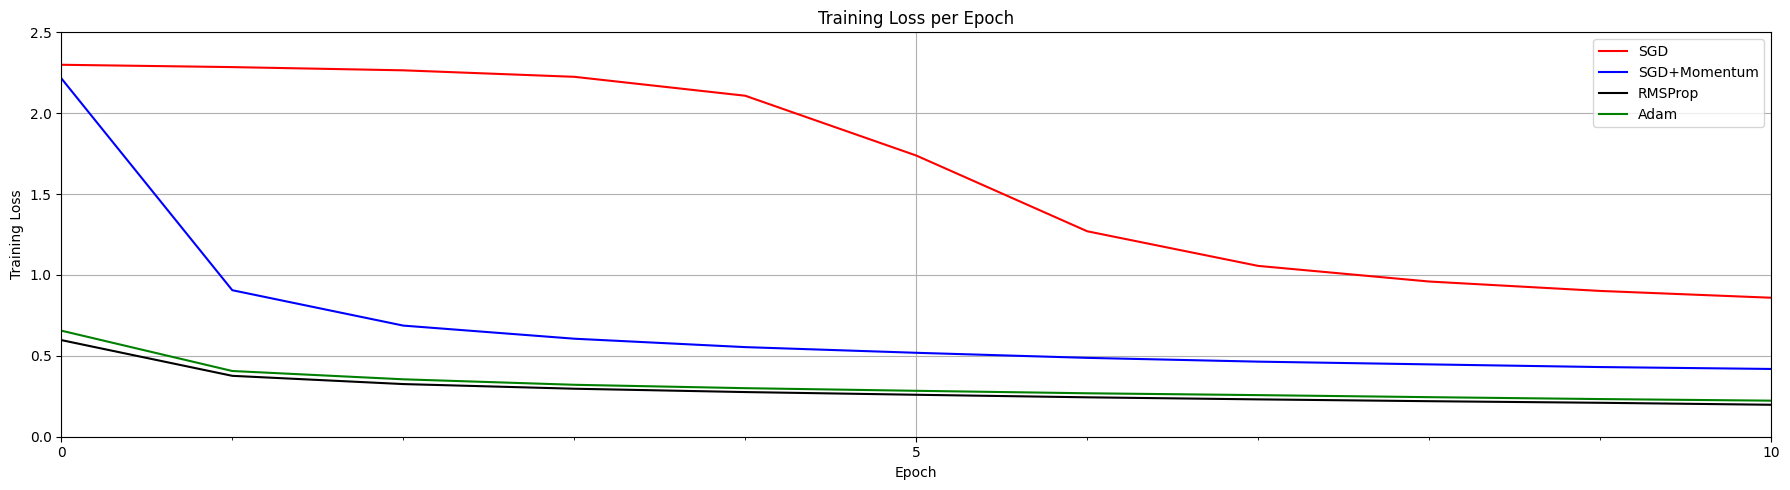

In [ ]:
plot_results(
    [train_loss_sgd, train_loss_sgd_m, train_loss_rprop, train_loss_adam],
    ylabel="Training Loss",
    ylim=[0.0, 2.5],
    metric_name=["SGD", "SGD+Momentum", "RMSProp", "Adam"],
    color=["r", "b", "k", "g"],
)

As shown in the plot above, SGD (red) has the highest loss of the four optimizers, while Adam (green) and RMSProp (black) eventually achieve the lowest loss. Also, notice that SGD+Momentum (blue) follows a very similar trend to Adam, though not quite as low. Initially, RMSProp (black) converges the fastest in the first 10-15 epochs, but at the end the curve is very similar to Adam. So for this model and dataset, Adam and RMSProp clearly perform better than SGD (+ momentum).

But there are a couple of caveats. First, recall that in each case, we used the constant learning rate for each optimizer, which is a good thing to do initially. Once you have a baseline, you can adjust the learning rates for each optimizer to see how that affects the results. Another option is to adjust the learning rate during the training process programmatically by using a learning rate scheduler (we will cover this topic in a future notebook). There is often some experimentation required for selecting the "best" type of optimizer as well as tunning it. The main point here is that it's a good idea to try several optimizers initially. Although *Adam* generally performs very well under a wide range of conditions, it is not necessarily the best choice for all problems, and you should at least experiment initially to see which optimizer looks best. Once you select an optimizer, it is often required to experiment further to finetune the training of your model.

### 10.2 Validation Loss

Although we often study validation loss when training models, this should not be the criteria by which an optimizer is selected, since the optimizer's job is to achieve fast and stable convergence on the training data. However, it is worth studying the validation loss in this case to make a few points.

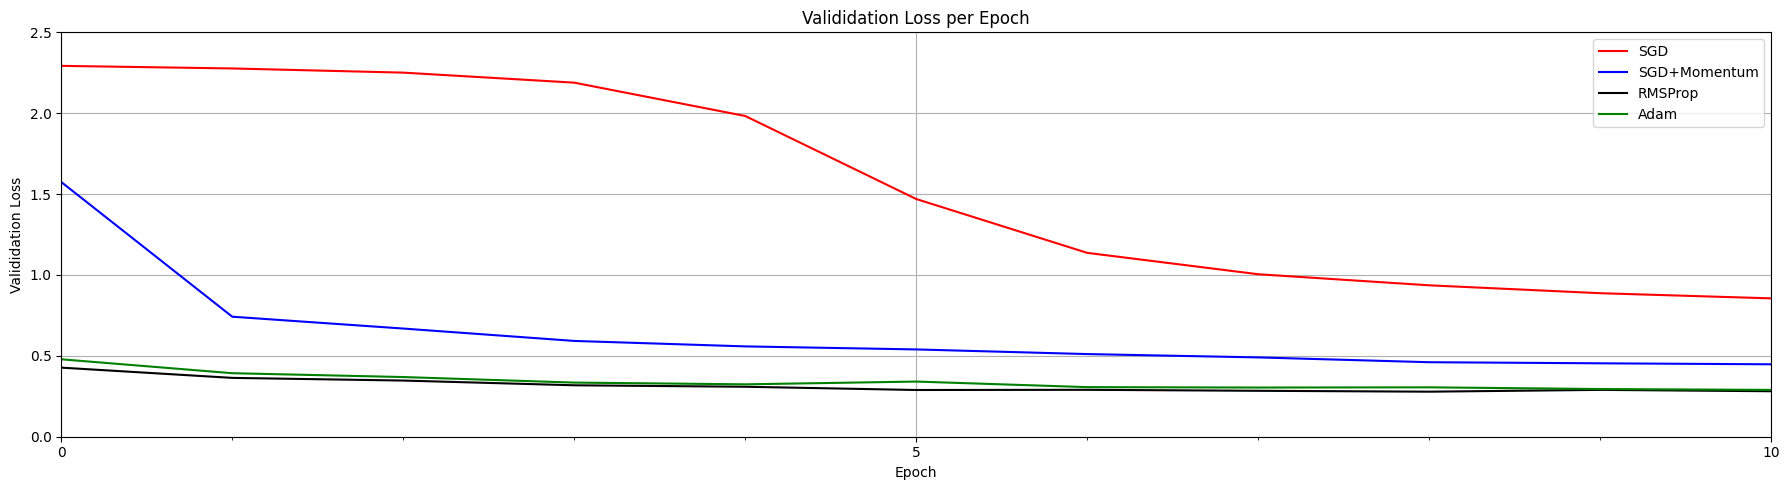

In [ ]:
plot_results(
    [valid_loss_sgd, valid_loss_sgd_m, valid_loss_rprop, valid_loss_adam],
    ylabel="Valididation Loss",
    ylim=[0.0, 2.5],
    metric_name=["SGD", "SGD+Momentum", "RMSProp", "Adam"],
    color=["r", "b", "k", "g"],
)

In the plot above, we first notice that loss for Adam & RMSProp optimizers start diverging after about 10-15 epochs. The SGD and SGD + momentum optimizer takes longer to converge but flattens out and does not really appear to diverge. So it can be tempting to conclude that SGD and SGD + momentum might be a good choice. But again, we need to remember that while validation loss is important for fine-tuning model and hyperparameters for a given optimizer, this should not be the criteria by which an optimizer is selected.

But if you compare these curves carefully, you will see that Adam, SGD+Momentum, and RMSProp all achieve about the same minimum (validation) loss which is lower than the SGD (red) optimizer, which takes much longer to reach its minimum value. So although we don't want to use validation loss as criteria for selecting the **type** of optimizer to use, the fact that the other three optimizers achieve a lower loss than SGD in just a few epochs is a good indication that they have better convergence properties than SGD.

## 11 Conclusion

The main takeaway from this notebook is that it is worth studying the convergence properties of several optimizers to determine which one might be best suited for your problem. And the most important point to remember is that this comparison should be performed on the training dataset. Initially, it's recommended that the default learning rate for each optimizer be used to establish a baseline as opposed to the same learning rate for each optimizer because each optimizer works differently internally. After an initial assessment, as we have done here, you may decide to experiment further with the learning rates to help inform you which optimizer might be best.